In [1]:
#Imports 
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

In [2]:
#Data is taken from a Kaggle Dataset and was downloaded "locally Medical Cost Personal Datasets"
#Import data into data frame (df) and view data .head()
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
#age: age of primary beneficiary
#sex: insurance contractor gender, female, male
#bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
#objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
#children: Number of children covered by health insurance / Number of dependents
#smoker: Smoking
#region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
#charges: Individual medical costs billed by health insurance

In [4]:
#Start with Data Exploration to understand what we have 
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
#Understand the format of the data and if we have any Null 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [15]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

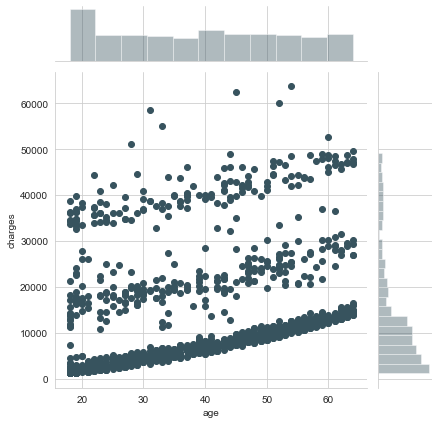

In [6]:
#Data viz with Seaborn 
sns.jointplot(x='age',y='charges',data=df)
#thought there would be a trend noticed here

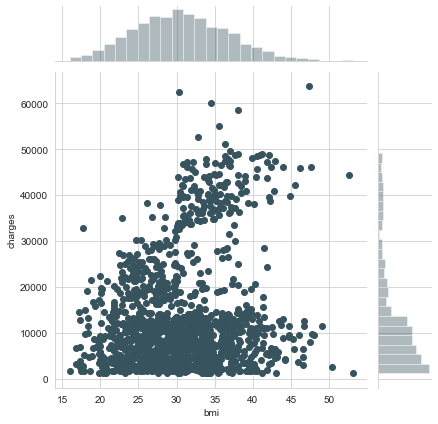

In [7]:
sns.jointplot(x='bmi',y='charges',data=df)
#Not as clear of a trend as I was anticipating, try adding hue = smoker 

C:\Users\brian\Anaconda3\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


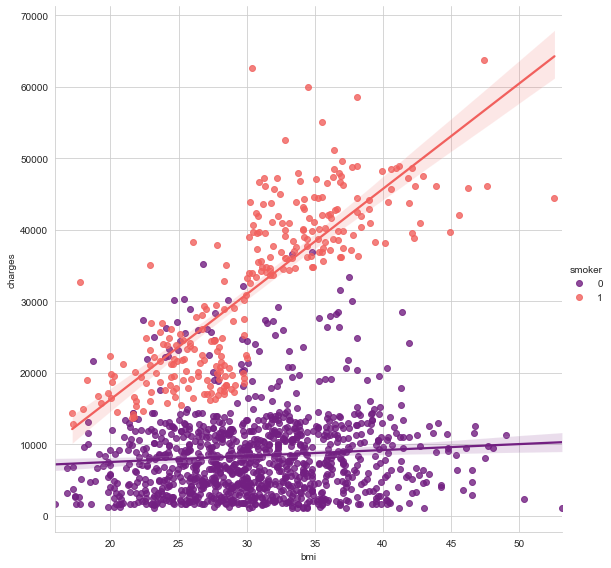

In [46]:
sns.lmplot(x="bmi", y="charges", hue="smoker", data=df, palette = 'magma', size = 8)
#BMI and smoking have a clear trend towards higher healthcare costs. 

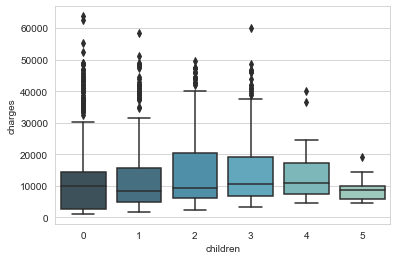

In [10]:
sns.boxplot(x='children',y='charges',data=df)

In [16]:
df['children'].value_counts()
#Want to understand how many occurances of 5 children. Not many. 

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

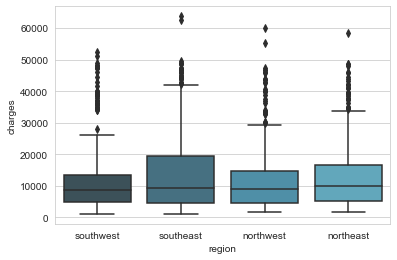

In [14]:
sns.boxplot(x='region',y='charges',data=df)
#does not appear to be a driving factor

In [20]:
#Sex, smoker region need to be converted to dummy variables 
#Note: Dummies vs. Encoder -> encoding may give impression that the 0 1 2 3 means something. 
#Dummies seperates this out 
dummies = pd.get_dummies(df['sex'],drop_first=True)
df = df.drop('sex',axis=1)
df = pd.concat([df,dummies],axis=1)

In [22]:
#do the same thing for smoking 
dummies_smoke = pd.get_dummies(df['smoker'],drop_first=True)
df = df.drop('smoker',axis=1)
df = pd.concat([df,dummies_smoke],axis=1)

In [25]:
#do the same thing for region 
dummies_region = pd.get_dummies(df['region'],drop_first=True)
df = df.drop('region',axis=1)
df = pd.concat([df,dummies_region],axis=1)

In [26]:
#Check out the dataframe to confirm implemented correctly 
df = df.rename(columns = {"yes":"smoker"})
df.head()

,age,bmi,children,charges,male,smoker,northwest,southeast,southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [27]:
#now that we have remove the object columns let's check the correlation 
df.corr()['charges'].sort_values()

southwest   -0.043210
northwest   -0.039905
male         0.057292
children     0.067998
southeast    0.073982
bmi          0.198341
age          0.299008
smoker       0.787251
charges      1.000000
Name: charges, dtype: float64

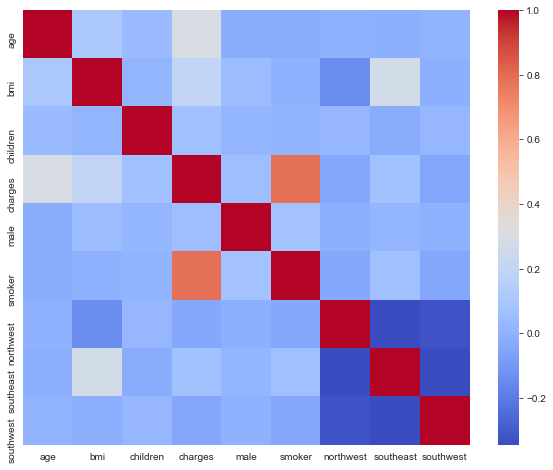

In [31]:
#Visual for correlation 
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm')
#Smoking has highest correlation. 

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

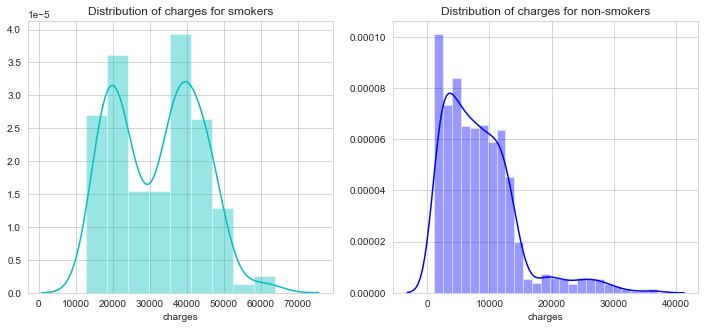

In [42]:
#let's focus on smoking
#set figure size for better viz
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(df[(df.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(df[(df.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

In [116]:
#setting up the regression model x and y variables 
#Based on EDA will not include region or sex
y = df['charges']
X= df[['bmi','age','smoker']]
#X = df.drop(['charges'],axis=1)

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [118]:
#Will test on 30% of data, passed in random state to shuffle data prior to splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [119]:
#Creating an instance (first object of lm) of the linear regression model 
lm = LinearRegression()

In [120]:
#train/fit lm on the training data
lm.fit(X_train,y_train)

LinearRegression()

In [121]:
# The coefficients
#How much the dependent variable (charges) increases when the independent variable associated with the coefficient increases
#by one
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [  354.87195555   243.37575572 23469.73560219]


In [122]:
predictions = lm.predict( X_test)

Text(0, 0.5, 'Predicted Y')

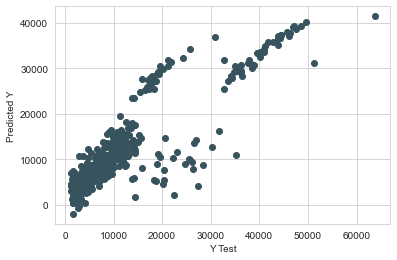

In [123]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [124]:
# calculate the metrics
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('R^2:', metrics.r2_score(y_test, predictions))
#print('MSE:', metrics.mean_squared_error(y_test, predictions))
#print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 4046.9883522195664
R^2: 0.7583790612051051


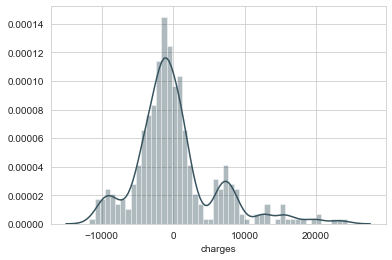

In [125]:
#Explore the residuals (deviations over the data sample )
sns.distplot((y_test-predictions),bins=50);